In [2]:
pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.0 MB/s eta 0:00:00


In [5]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


Import necessary libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, TimeDistributed, RepeatVector
from keras.optimizers import Adam
import tensorflow as tf
from tcn import TCN
import keras_tuner as kt
from tensorflow import keras
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [10]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/wind-power-production-us.csv')

In [17]:
data.head()

,date,other_united_states,other_new_england,other_connecticut,other_maine,other_massachusetts,other_new_hampshire,other_rhode_island,other_vermont,other_middle_atlantic,...,wind_new_mexico,wind_utah,wind_wyoming,wind_pacific_contiguous,wind_california,wind_oregon,wind_washington,wind_pacific_noncontiguous,wind_alaska,wind_hawaii
0,Jan 2001,6025,678,75,348,113,91,10,42,371,...,--,--,26,137,133,3,--,0,0,0
1,Feb 2001,5310,599,77,293,103,83,9,35,338,...,--,--,23,151,148,3,--,0,0,0
2,Mar 2001,5795,660,96,327,101,93,9,33,381,...,--,--,22,308,300,8,--,0,0,0
3,Apr 2001,5827,593,92,277,106,81,9,27,361,...,--,--,13,399,393,6,--,0,0,0
4,May 2001,5738,640,72,336,109,86,9,27,392,...,--,--,16,383,378,6,--,0,0,0


# Data Preprocessing

In [18]:
## Select relevant columns
data = data[['date', 'wind_united_states', 'other_united_states']]

In [19]:
## Replace '--' with NaN
data.replace('--', np.nan, inplace=True)

In [20]:
## Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], format='%b %Y')

In [21]:
## Set the date column as index
data.set_index('date', inplace=True)

In [22]:
## Remove duplicates
data.drop_duplicates(inplace=True)

In [24]:
## Convert all columns to numeric (except 'date')
data = data.apply(pd.to_numeric, errors='coerce')

In [28]:
## Fill remaining NaNs (if any) by forward fill and backfill
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

In [29]:
## Replace zero values with column mean
for column in data.columns:
    data[column] = data[column].replace(0, data[column].mean())

In [30]:
## Check for any remaining NaNs
print("NaN values after initial cleaning:")
print(data.isnull().sum())

NaN values after initial cleaning:
wind_united_states     0
other_united_states    0
dtype: int64


In [31]:
data.head()

,wind_united_states,other_united_states
date,,
2001-01-01,389,6025
2001-02-01,431,5310
2001-03-01,532,5795
2001-04-01,685,5827
2001-05-01,635,5738


# Exploratory Data Analysis (EDA)

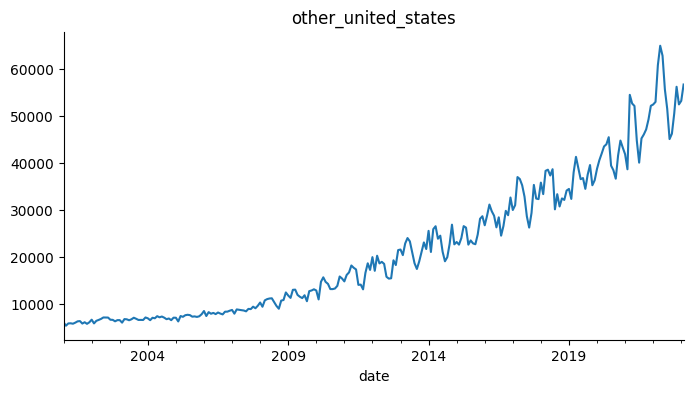

In [32]:
# @title other_united_states

from matplotlib import pyplot as plt
data['other_united_states'].plot(kind='line', figsize=(8, 4), title='other_united_states')
plt.gca().spines[['top', 'right']].set_visible(False)

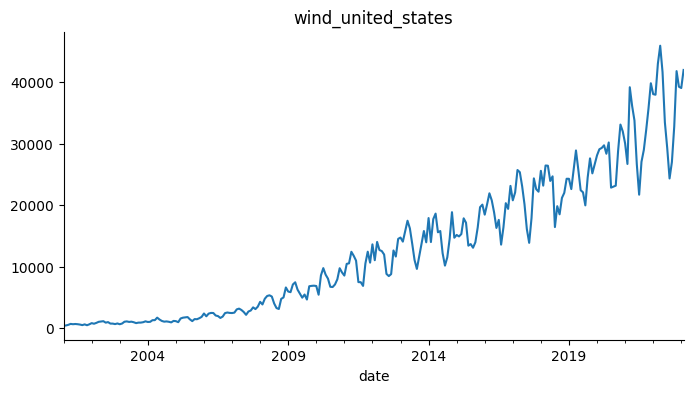

In [33]:
# @title wind_united_states

from matplotlib import pyplot as plt
data['wind_united_states'].plot(kind='line', figsize=(8, 4), title='wind_united_states')
plt.gca().spines[['top', 'right']].set_visible(False)

ACF and PACF for 'other_united_states'

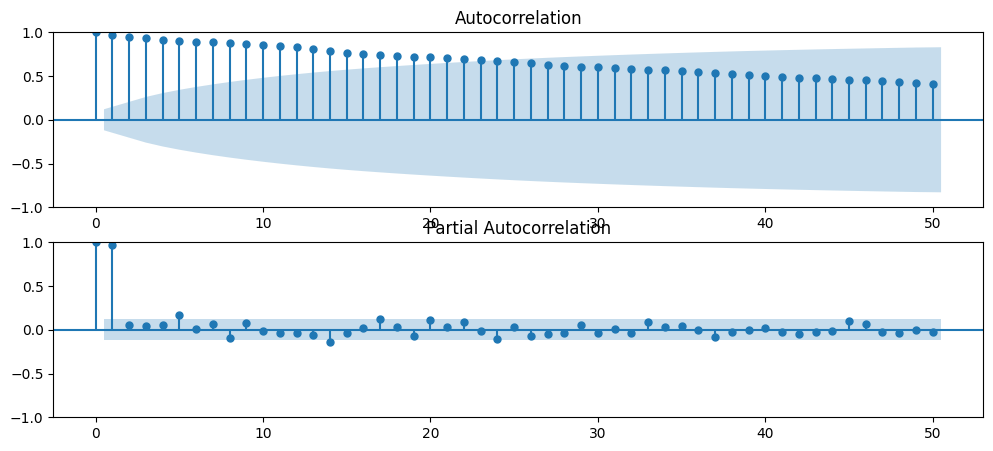

In [36]:
## ACF and PACF for 'other_united_states'
plt.figure(figsize=(12, 5))
plot_acf(data['other_united_states'], lags=50, ax=plt.subplot(2,1,1))
plot_pacf(data['other_united_states'], lags=50, ax=plt.subplot(2,1,2))
plt.show()

ACF and PACF for 'wind_united_states'

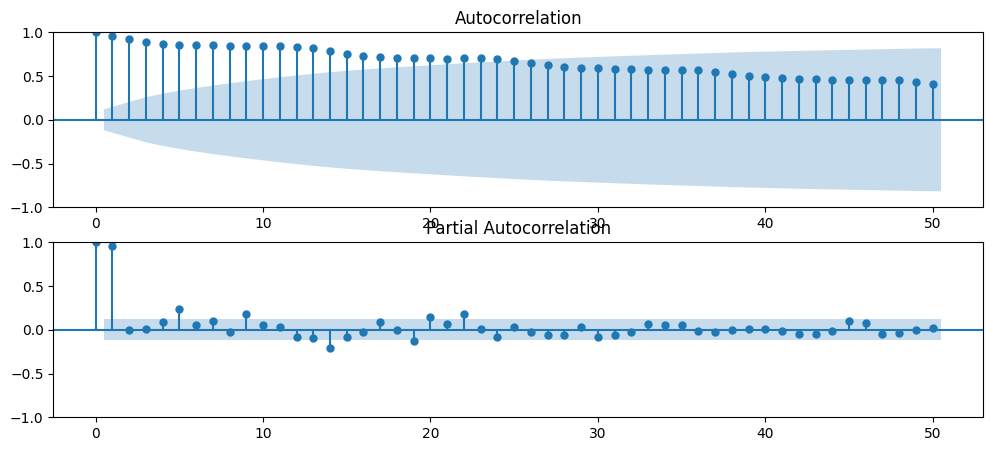

In [37]:
##
plt.figure(figsize=(12, 5))
plot_acf(data['wind_united_states'], lags=50, ax=plt.subplot(2,1,1))
plot_pacf(data['wind_united_states'], lags=50, ax=plt.subplot(2,1,2))
plt.show()

Histogram for 'other_united_states'

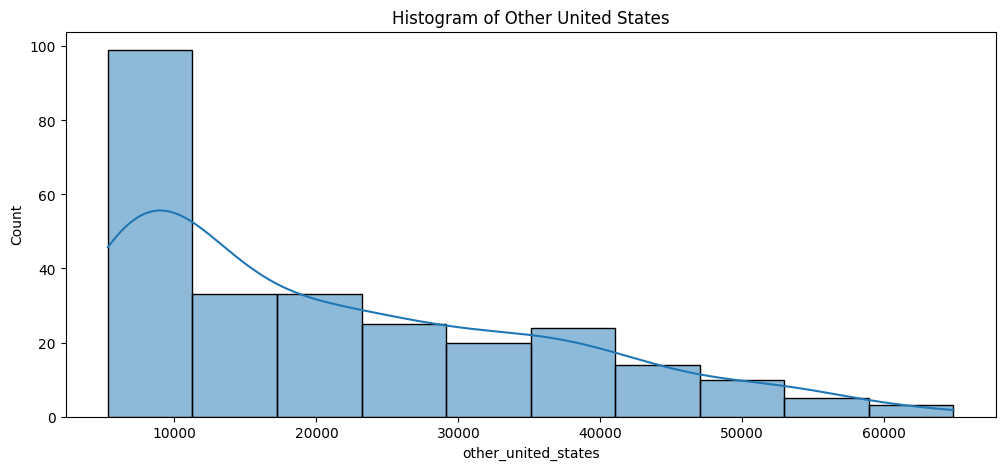

In [38]:
## Histograms
###
plt.figure(figsize=(12, 5))
sns.histplot(data['other_united_states'], kde=True)
plt.title('Histogram of Other United States')
plt.show()

Histogram for 'wind_united_states'

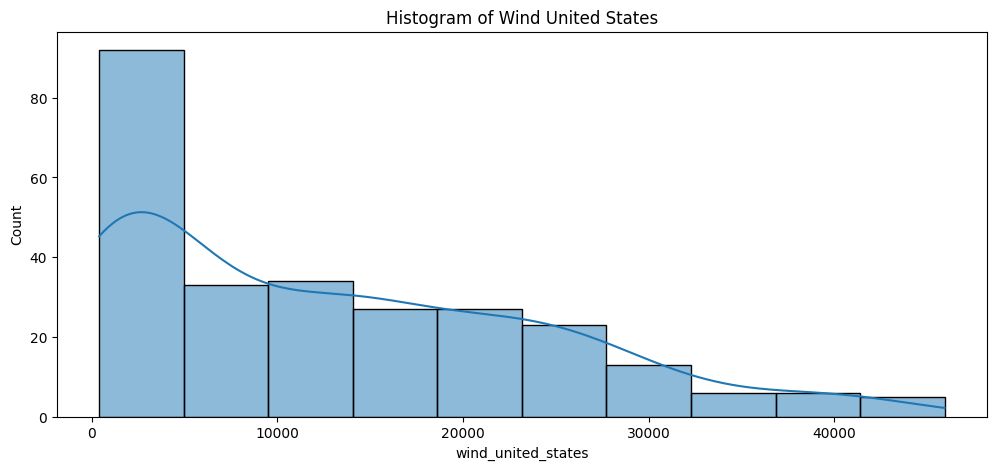

In [40]:
###
plt.figure(figsize=(12, 5))
sns.histplot(data['wind_united_states'], kde=True)
plt.title('Histogram of Wind United States')
plt.show()

Correlation Heatmap

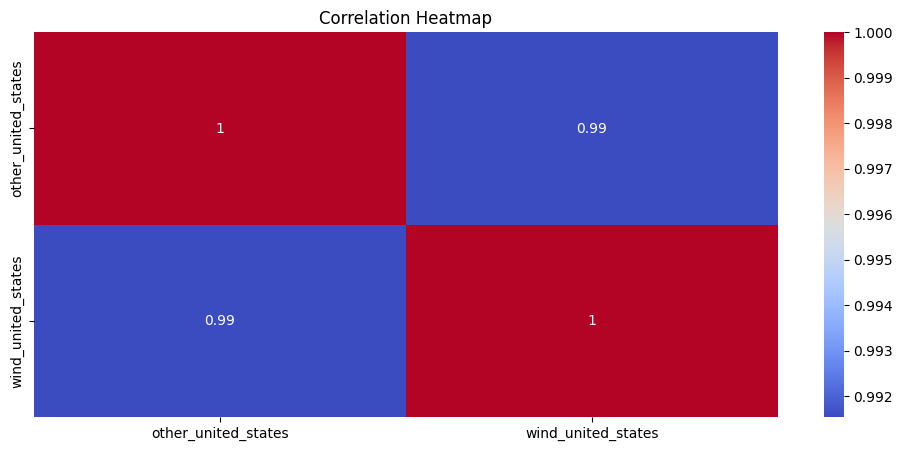

In [41]:
##
plt.figure(figsize=(12, 5))
sns.heatmap(data[['other_united_states', 'wind_united_states']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Descriptive Statistics

In [42]:
##
desc_stats = data[['other_united_states', 'wind_united_states']].describe()
print(desc_stats)

       other_united_states  wind_united_states
count           266.000000          266.000000
mean          21369.578947        12888.214286
std           14675.645809        11305.680657
min            5310.000000          389.000000
25%            8057.250000         2365.000000
50%           17333.000000        10820.500000
75%           32203.750000        21095.250000
max           64877.000000        45960.000000


Seasonal Decomposition

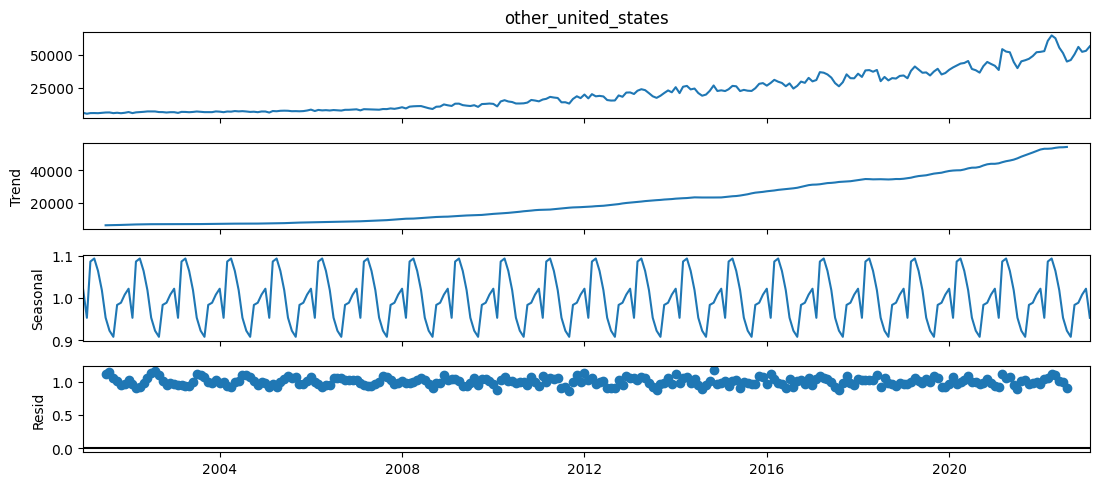

In [44]:
##
decomposition = seasonal_decompose(data['other_united_states'], model='multiplicative', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 5)
plt.show()

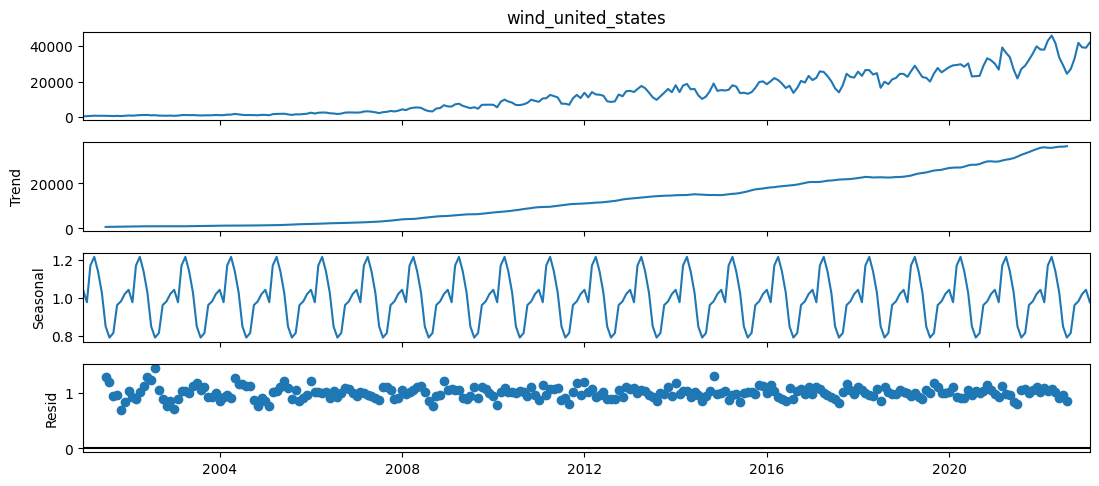

In [45]:
decomposition = seasonal_decompose(data['wind_united_states'], model='multiplicative', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 5)
plt.show()

Function to plot the original and differenced series

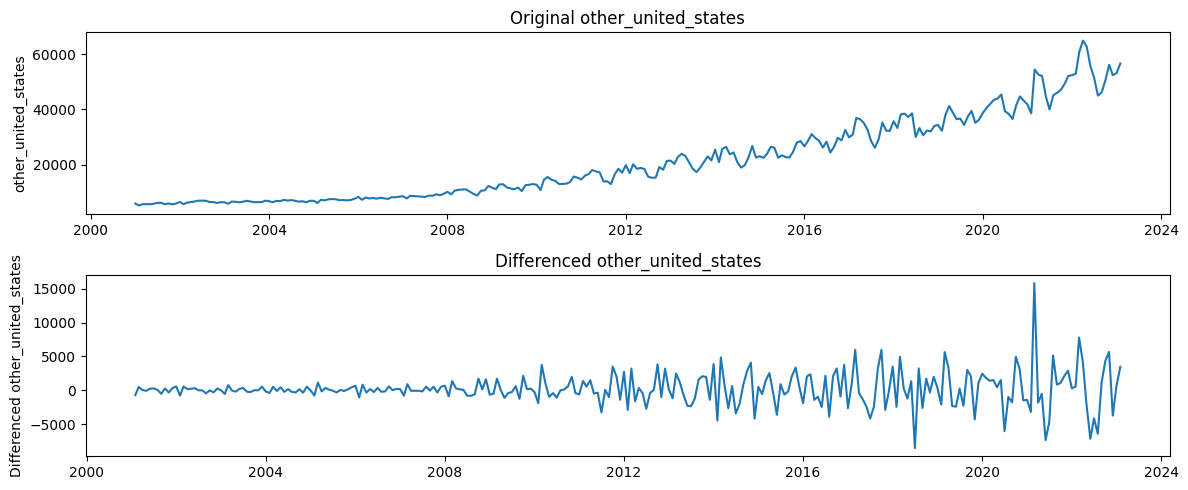

ADF Statistic for original other_united_states: 2.569518595527602
p-value for original other_united_states: 0.9990688922943036
ADF Statistic for differenced other_united_states: -3.1092446734766335
p-value for differenced other_united_states: 0.025876562820924185


In [47]:
##
def plot_series_and_differenced(series, series_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 1, 1)
    plt.plot(data.index, series)
    plt.title(f'Original {series_name}')
    plt.ylabel(series_name)
    differenced_series = series.diff().dropna()
    plt.subplot(2, 1, 2)
    plt.plot(data.index[1:], differenced_series)
    plt.title(f'Differenced {series_name}')
    plt.ylabel(f'Differenced {series_name}')
    plt.tight_layout()
    plt.show()
    result_original = adfuller(series)
    print(f'ADF Statistic for original {series_name}: {result_original[0]}')
    print(f'p-value for original {series_name}: {result_original[1]}')
    result_differenced = adfuller(differenced_series)
    print(f'ADF Statistic for differenced {series_name}: {result_differenced[0]}')
    print(f'p-value for differenced {series_name}: {result_differenced[1]}')

plot_series_and_differenced(data['other_united_states'], 'other_united_states')


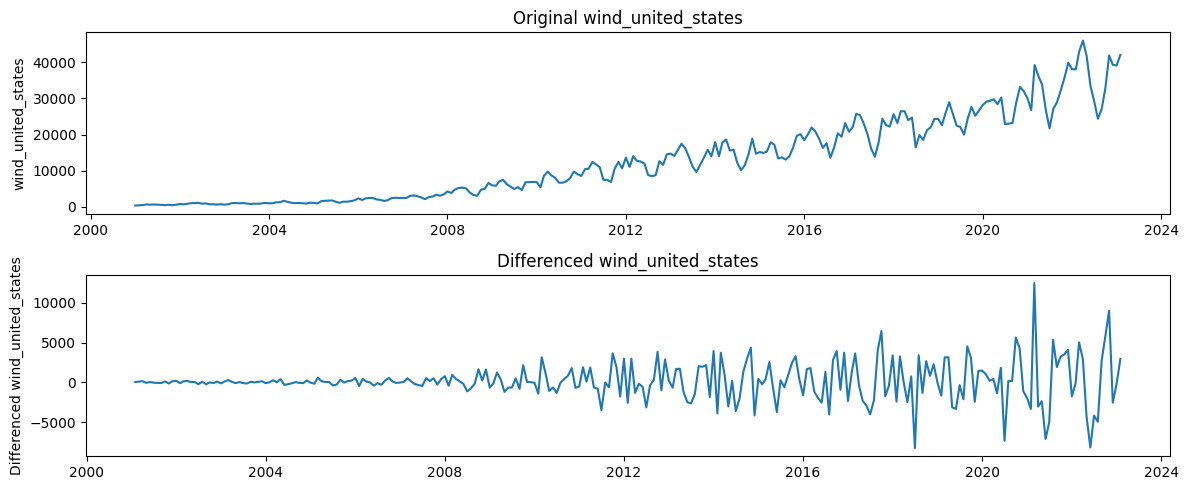

ADF Statistic for original wind_united_states: 2.3890096360511244
p-value for original wind_united_states: 0.9990050433476562
ADF Statistic for differenced wind_united_states: -3.9561471642118575
p-value for differenced wind_united_states: 0.001658371083395317


In [48]:
plot_series_and_differenced(data['wind_united_states'], 'wind_united_states')

Rolling Statistics

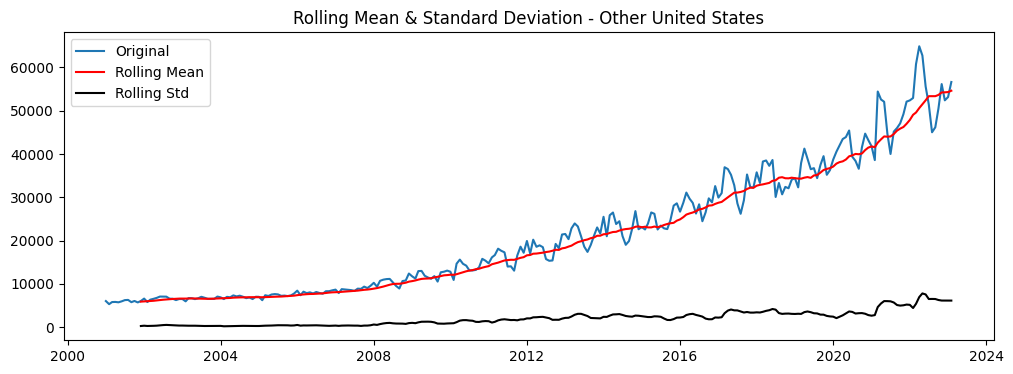

In [49]:
##
plt.figure(figsize=(12, 4))
rolling_mean = data['other_united_states'].rolling(window=12).mean()
rolling_std = data['other_united_states'].rolling(window=12).std()
plt.plot(data.index, data['other_united_states'], label='Original')
plt.plot(data.index, rolling_mean, label='Rolling Mean', color='red')
plt.plot(data.index, rolling_std, label='Rolling Std', color='black')
plt.title('Rolling Mean & Standard Deviation - Other United States')
plt.legend()
plt.show()

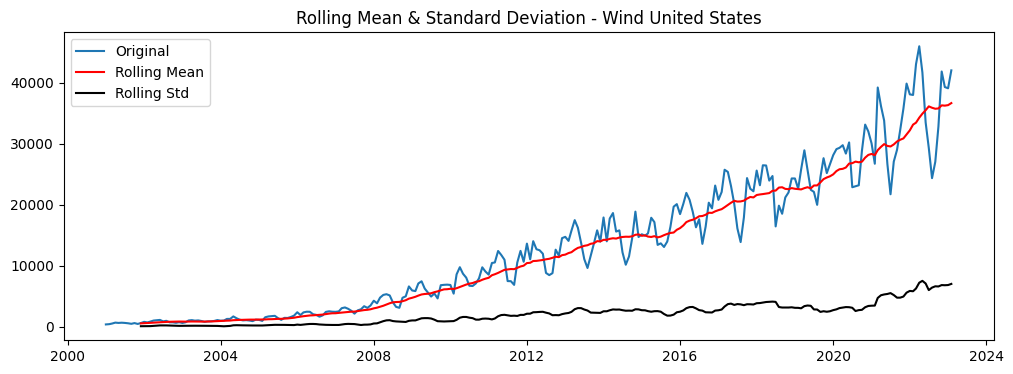

In [50]:
plt.figure(figsize=(12, 4))
rolling_mean = data['wind_united_states'].rolling(window=12).mean()
rolling_std = data['wind_united_states'].rolling(window=12).std()
plt.plot(data.index, data['wind_united_states'], label='Original')
plt.plot(data.index, rolling_mean, label='Rolling Mean', color='red')
plt.plot(data.index, rolling_std, label='Rolling Std', color='black')
plt.title('Rolling Mean & Standard Deviation - Wind United States')
plt.legend()
plt.show()

Box Plot by Month

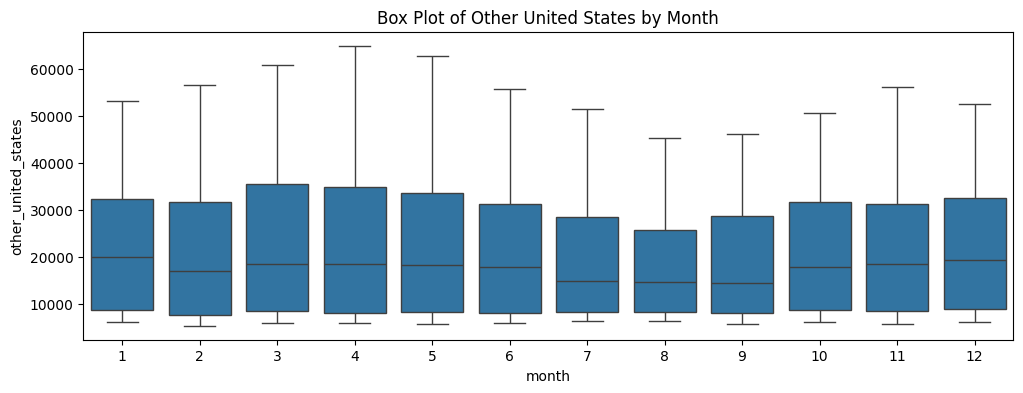

In [51]:
##
data['month'] = data.index.month
plt.figure(figsize=(12, 4))
sns.boxplot(x='month', y='other_united_states', data=data)
plt.title('Box Plot of Other United States by Month')
plt.show()


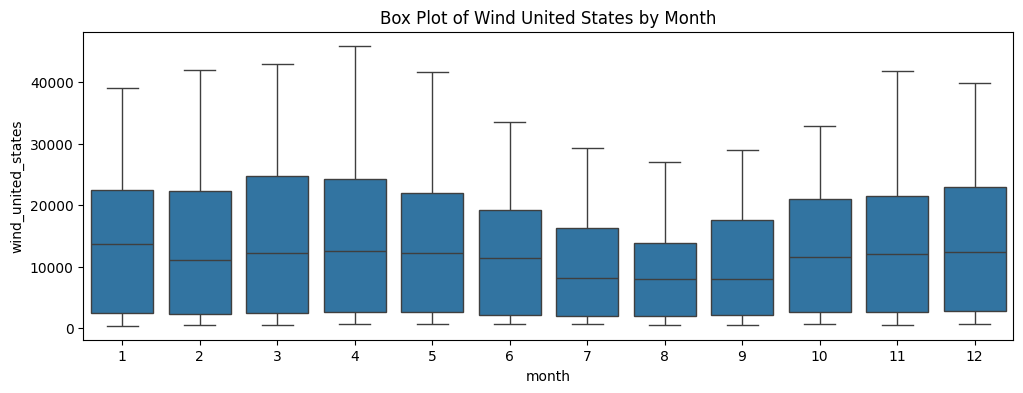

In [52]:
plt.figure(figsize=(12, 4))
sns.boxplot(x='month', y='wind_united_states', data=data)
plt.title('Box Plot of Wind United States by Month')
plt.show()

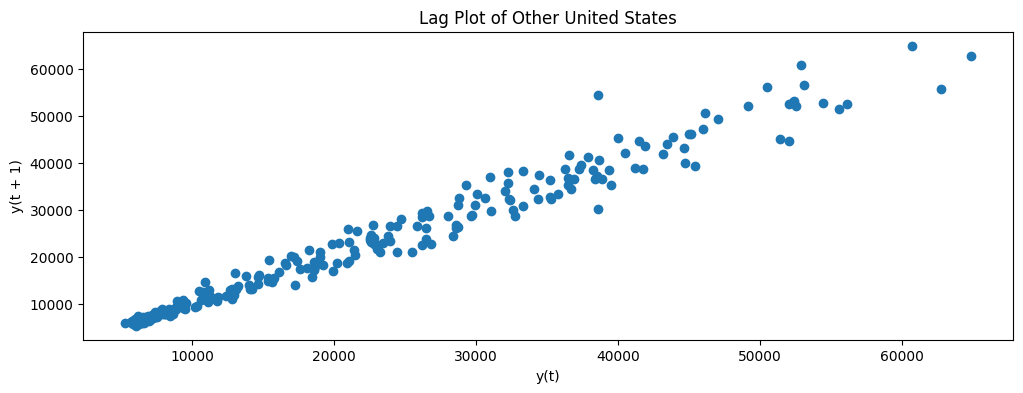

In [53]:
## Lag Plot


plt.figure(figsize=(12, 4))
lag_plot(data['other_united_states'])
plt.title('Lag Plot of Other United States')
plt.show()


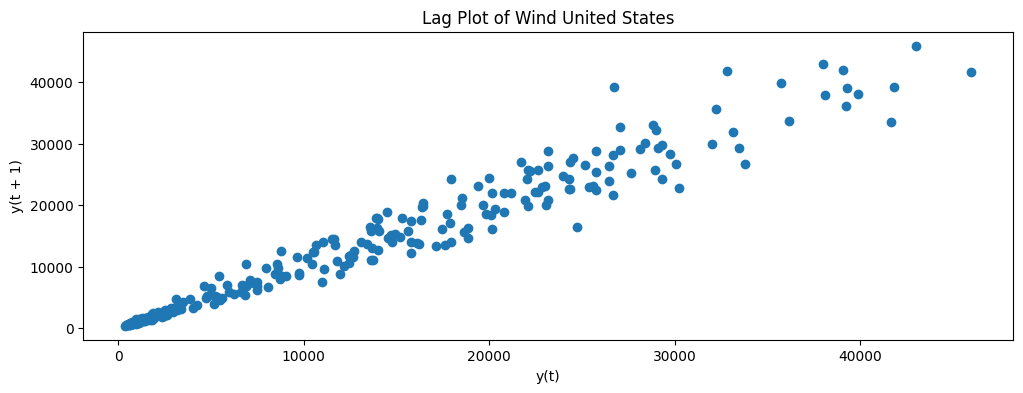

In [54]:

plt.figure(figsize=(12, 4))
lag_plot(data['wind_united_states'])
plt.title('Lag Plot of Wind United States')
plt.show()

# Data Preparation

Split the data into training (60%), validation (20%), and testing (20%) sets

In [56]:
##
train_data, temp_data = train_test_split(data, test_size=0.4, shuffle=False)
val_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=False)

Standardize the data

In [57]:
##
scalers = {}
for col in ['wind_united_states', 'other_united_states']:
    scaler = StandardScaler()
    train_data[col] = scaler.fit_transform(train_data[col].values.reshape(-1, 1))
    val_data[col] = scaler.transform(val_data[col].values.reshape(-1, 1))
    test_data[col] = scaler.transform(test_data[col].values.reshape(-1, 1))
    scalers[col] = scaler

Extract features and targets for model training

In [58]:
##
X_train = train_data[['other_united_states']]
y_train = train_data[['wind_united_states']]
X_val = val_data[['other_united_states']]
y_val = val_data[['wind_united_states']]
X_test = test_data[['other_united_states']]
y_test = test_data[['wind_united_states']]

Reshape data for LSTM and CNN-LSTM

In [60]:
##
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_lstm = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

Reshape data for TCN (Keras expects shape: (samples, timesteps, features))

In [61]:
##
X_train_tcn = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_tcn = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_tcn = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

Shapes of the reshaped data

In [62]:
print("Shapes of the reshaped data:")
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_val_lstm shape:", X_val_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)
print("X_train_tcn shape:", X_train_tcn.shape)
print("X_val_tcn shape:", X_val_tcn.shape)
print("X_test_tcn shape:", X_test_tcn.shape)

Shapes of the reshaped data:
X_train_lstm shape: (159, 1, 1)
X_val_lstm shape: (53, 1, 1)
X_test_lstm shape: (54, 1, 1)
X_train_tcn shape: (159, 1, 1)
X_val_tcn shape: (53, 1, 1)
X_test_tcn shape: (54, 1, 1)


# Statistical Models

### ARIMA Model

Fit ARIMA model for 'other_united_states'

In [102]:
# Define a function to fit ARIMA model
def fit_arima(train, order):
    model = sm.tsa.ARIMA(train, order=order)
    fitted_model = model.fit()
    return fitted_model

In [362]:
# Fit ARIMA model for 'other_united_states'
arima_order = (26,2,1)  # Example order, adjust as needed
arima_model_other_us = fit_arima(train_data['other_united_states'], arima_order)
print(arima_model_other_us.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

                                SARIMAX Results                                
Dep. Variable:     other_united_states   No. Observations:                  159
Model:                 ARIMA(26, 2, 1)   Log Likelihood                  88.930
Date:                 Sat, 01 Jun 2024   AIC                           -121.861
Time:                         16:36:36   BIC                            -36.286
Sample:                     01-01-2001   HQIC                           -87.106
                          - 03-01-2014                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7191      0.251     -2.869      0.004      -1.210      -0.228
ar.L2         -0.4923      0.372     -1.324      0.186      -1.221       0.237
ar.L3         -0.5173      0.434     -1.193 

Fit ARIMA model for 'wind_united_states'

In [363]:
###
arima_model_wind_us = fit_arima(train_data['wind_united_states'], order=arima_order)
print(arima_model_wind_us.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

                               SARIMAX Results                                
Dep. Variable:     wind_united_states   No. Observations:                  159
Model:                ARIMA(26, 2, 1)   Log Likelihood                  89.304
Date:                Sat, 01 Jun 2024   AIC                           -122.609
Time:                        16:36:45   BIC                            -37.034
Sample:                    01-01-2001   HQIC                           -87.854
                         - 03-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6749      0.183     -3.690      0.000      -1.033      -0.316
ar.L2         -0.4440      0.258     -1.722      0.085      -0.949       0.061
ar.L3         -0.4679      0.287     -1.633      0.1

Make predictions

In [364]:
###
arima_forecast_other_us = arima_model_other_us.forecast(steps=len(test_data))
arima_forecast_wind_us = arima_model_wind_us.forecast(steps=len(test_data))

Evaluate ARIMA models

In [365]:
###
arima_forecast_other_us = np.array(arima_forecast_other_us).reshape(-1, 1)
arima_forecast_wind_us = np.array(arima_forecast_wind_us).reshape(-1, 1)

In [366]:
mse, mae, r2 = mean_squared_error(test_data['other_united_states'], arima_forecast_other_us), mean_absolute_error(test_data['other_united_states'], arima_forecast_other_us), r2_score(test_data['other_united_states'], arima_forecast_other_us)
print(f"ARIMA 'other_united_states' - MSE: {mse}, MAE: {mae}, R2: {r2}")

ARIMA 'other_united_states' - MSE: 10.379434740185696, MAE: 2.9886804060125134, R2: -3.054886211855316


In [367]:
mse, mae, r2 = mean_squared_error(test_data['wind_united_states'], arima_forecast_wind_us), mean_absolute_error(test_data['wind_united_states'], arima_forecast_wind_us), r2_score(test_data['wind_united_states'], arima_forecast_wind_us)
print(f"ARIMA 'wind_united_states' - MSE: {mse}, MAE: {mae}, R2: {r2}")

ARIMA 'wind_united_states' - MSE: 6.360390925733487, MAE: 2.1584302389855954, R2: -2.1925311821294478


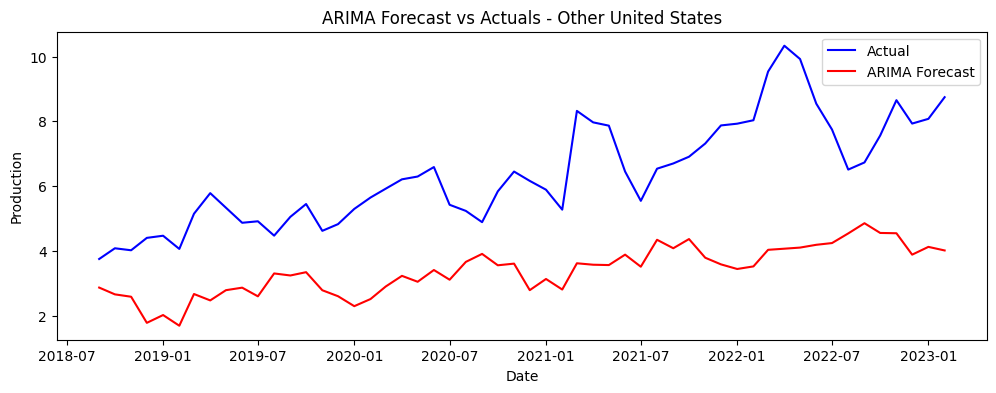

In [368]:
### Plot ARIMA forecast vs actuals for 'other_united_states'
plt.figure(figsize=(12, 4))
plt.plot(test_data.index, test_data['other_united_states'], label='Actual', color='blue')
plt.plot(test_data.index, arima_forecast_other_us, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actuals - Other United States')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

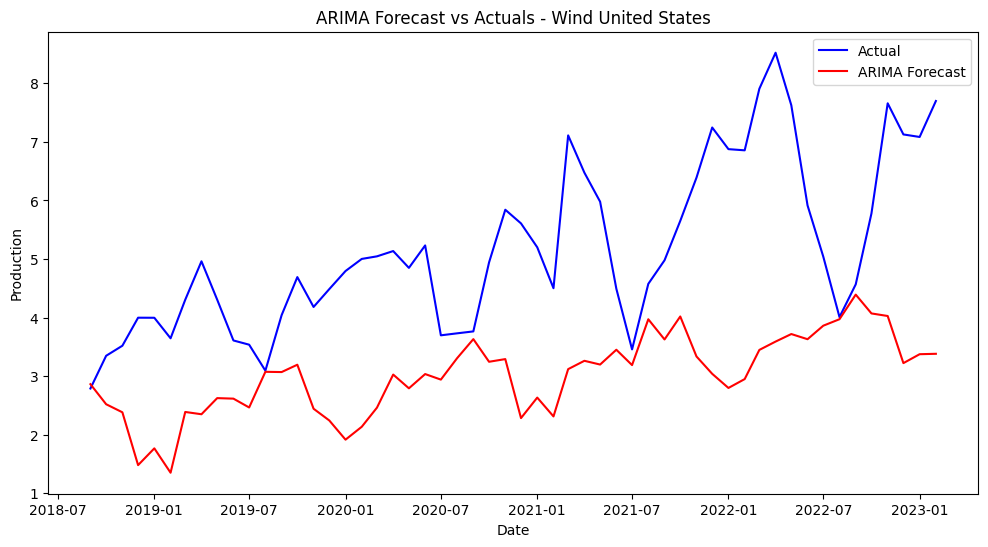

In [369]:
### Plot ARIMA forecast vs actuals for 'wind_united_states'
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['wind_united_states'], label='Actual', color='blue')
plt.plot(test_data.index, arima_forecast_wind_us, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actuals - Wind United States')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()


### SARIMA Model

In [372]:
# Define a function to fit SARIMA model
def fit_sarima(train, order, seasonal_order):
    model = sm.tsa.SARIMAX(train, order=order, seasonal_order=seasonal_order)
    fitted_model = model.fit()
    return fitted_model


In [374]:
# Fit SARIMA model for 'other_united_states'
sarima_order = (5, 1, 0)  # Example order, adjust as needed
sarima_seasonal_order = (1, 1, 1, 12)  # Example seasonal order, adjust as needed
sarima_model_other_us = fit_sarima(train_data['other_united_states'], sarima_order, sarima_seasonal_order)
print(sarima_model_other_us.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                  other_united_states   No. Observations:                  159
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 12)   Log Likelihood                  59.650
Date:                              Sat, 01 Jun 2024   AIC                           -103.299
Time:                                      16:38:43   BIC                            -79.430
Sample:                                  01-01-2001   HQIC                           -93.601
                                       - 03-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6616      0.072     -9.127      0.000      -0.804      -0.520
ar.L2         -0.18

In [375]:
# Fit SARIMA model for 'wind_united_states'
sarima_model_wind_us = fit_sarima(train_data['wind_united_states'], sarima_order, sarima_seasonal_order)
print(sarima_model_wind_us.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                   wind_united_states   No. Observations:                  159
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 12)   Log Likelihood                  50.218
Date:                              Sat, 01 Jun 2024   AIC                            -84.436
Time:                                      16:38:50   BIC                            -60.567
Sample:                                  01-01-2001   HQIC                           -74.737
                                       - 03-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6569      0.074     -8.848      0.000      -0.802      -0.511
ar.L2         -0.18

In [376]:
### Make predictions
sarima_forecast_other_us = sarima_model_other_us.forecast(steps=len(test_data))
sarima_forecast_wind_us = sarima_model_wind_us.forecast(steps=len(test_data))

In [377]:
### Evaluate SARIMA models
sarima_forecast_other_us = np.array(sarima_forecast_other_us).reshape(-1, 1)
sarima_forecast_wind_us = np.array(sarima_forecast_wind_us).reshape(-1, 1)

In [378]:
mse, mae, r2 = mean_squared_error(test_data['other_united_states'], sarima_forecast_other_us), mean_absolute_error(test_data['other_united_states'], sarima_forecast_other_us), r2_score(test_data['other_united_states'], sarima_forecast_other_us)
print(f"SARIMA 'other_united_states' - MSE: {mse}, MAE: {mae}, R2: {r2}")

mse, mae, r2 = mean_squared_error(test_data['wind_united_states'], sarima_forecast_wind_us), mean_absolute_error(test_data['wind_united_states'], sarima_forecast_wind_us), r2_score(test_data['wind_united_states'], sarima_forecast_wind_us)
print(f"SARIMA 'wind_united_states' - MSE: {mse}, MAE: {mae}, R2: {r2}")


SARIMA 'other_united_states' - MSE: 11.218789159142009, MAE: 3.1125807856414656, R2: -3.382792956825601
SARIMA 'wind_united_states' - MSE: 7.358488294393458, MAE: 2.3376511485228635, R2: -2.693515635672426


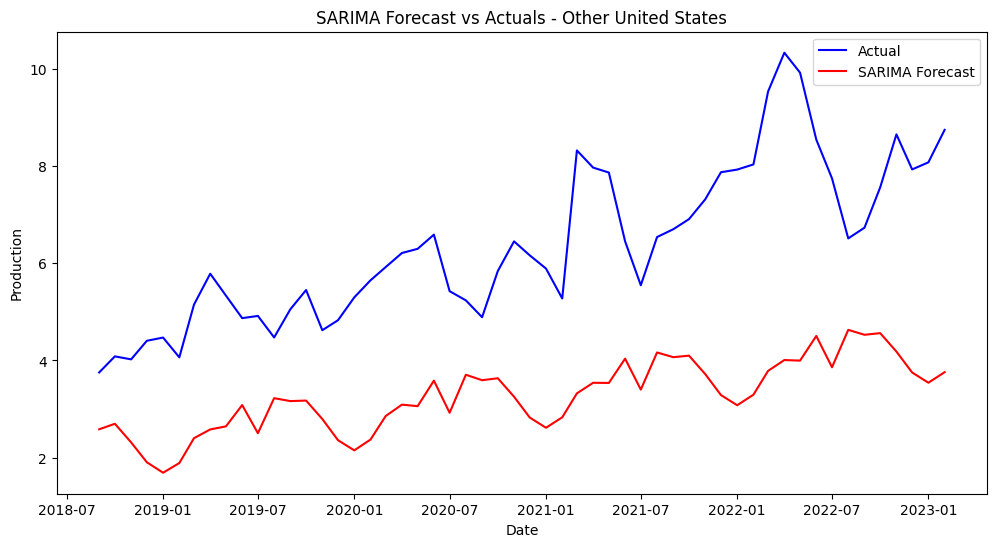

In [379]:
### Plot SARIMA forecast vs actuals for 'other_united_states'
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['other_united_states'], label='Actual', color='blue')
plt.plot(test_data.index, sarima_forecast_other_us, label='SARIMA Forecast', color='red')
plt.title('SARIMA Forecast vs Actuals - Other United States')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

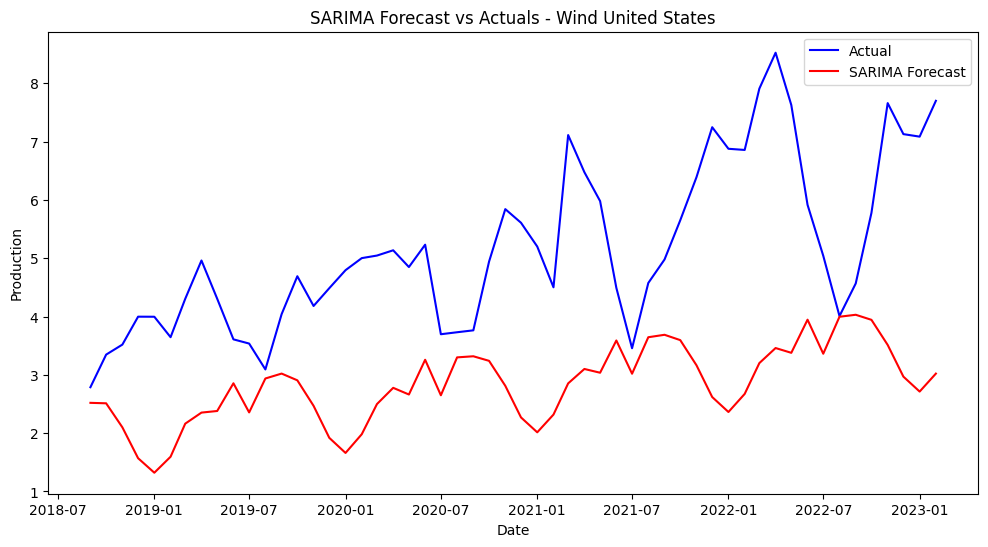

In [380]:
### Plot SARIMA forecast vs actuals for 'wind_united_states'
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['wind_united_states'], label='Actual', color='blue')
plt.plot(test_data.index, sarima_forecast_wind_us, label='SARIMA Forecast', color='red')
plt.title('SARIMA Forecast vs Actuals - Wind United States')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

### ARIMAX Model

In [149]:
# Define a function to fit ARIMAX model
def fit_arimax(train, exog, order):
    model = sm.tsa.ARIMA(train, exog=exog, order=order)
    fitted_model = model.fit()
    return fitted_model

# Fit ARIMAX model for 'other_united_states' using exogenous variable 'wind_united_states'
arimax_model_other_us = fit_arimax(train_data['other_united_states'], train_data['wind_united_states'], arima_order)
print(arimax_model_other_us.summary())

# Make predictions
arimax_forecast_other_us = arimax_model_other_us.forecast(steps=len(test_data), exog=test_data['wind_united_states'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

                                SARIMAX Results                                
Dep. Variable:     other_united_states   No. Observations:                  159
Model:                 ARIMA(27, 2, 2)   Log Likelihood                 340.138
Date:                 Sat, 01 Jun 2024   AIC                           -618.275
Time:                         15:04:13   BIC                           -523.531
Sample:                     01-01-2001   HQIC                          -579.796
                          - 03-01-2014                                         
Covariance Type:                   opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
wind_united_states     0.9129      0.017     53.582      0.000       0.880       0.946
ar.L1                 -0.4517      1.778     -0.254      0.799      -3.936       3.032
ar.L2       

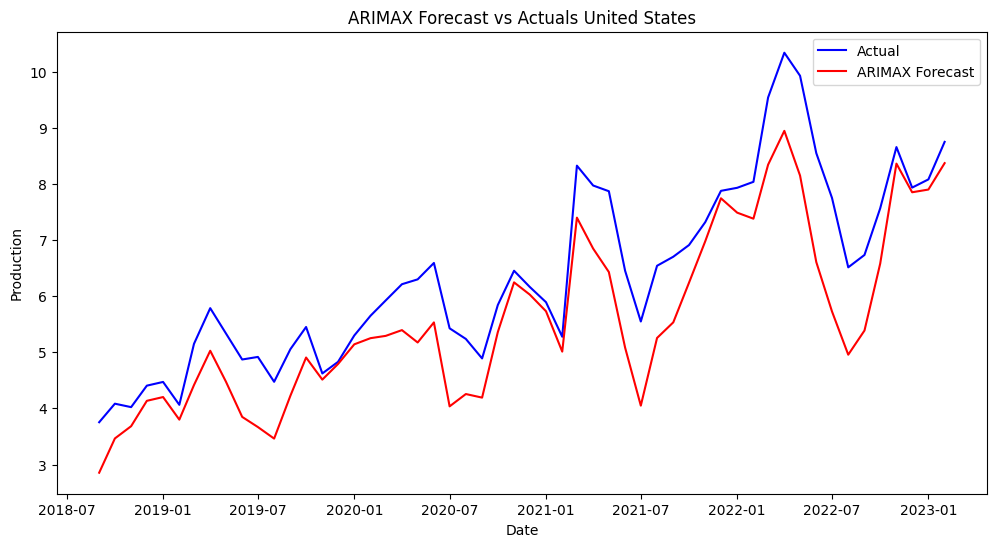

In [154]:
# Plot ARIMAX forecast vs actuals for 'other_united_states'
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['other_united_states'], label='Actual', color='blue')
plt.plot(test_data.index, arimax_forecast_other_us, label='ARIMAX Forecast', color='red')
plt.title('ARIMAX Forecast vs Actuals United States')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

In [155]:
# Define a function to fit SARIMAX model
def fit_sarimax(train, exog, order, seasonal_order):
    model = sm.tsa.SARIMAX(train, exog=exog, order=order, seasonal_order=seasonal_order)
    fitted_model = model.fit()
    return fitted_model

# Fit SARIMAX model for 'other_united_states' using exogenous variable 'wind_united_states'
sarimax_model_other_us = fit_sarimax(train_data['other_united_states'], train_data['wind_united_states'], sarima_order, sarima_seasonal_order)
print(sarimax_model_other_us.summary())

# Make predictions
sarimax_forecast_other_us = sarimax_model_other_us.forecast(steps=len(test_data), exog=test_data['wind_united_states'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                  other_united_states   No. Observations:                  159
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 334.956
Date:                              Sat, 01 Jun 2024   AIC                           -651.912
Time:                                      15:06:42   BIC                           -625.059
Sample:                                  01-01-2001   HQIC                          -641.001
                                       - 03-01-2014                                         
Covariance Type:                                opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
wind_united_states     0.9146      0.015     61.532      0.000       0.885       0

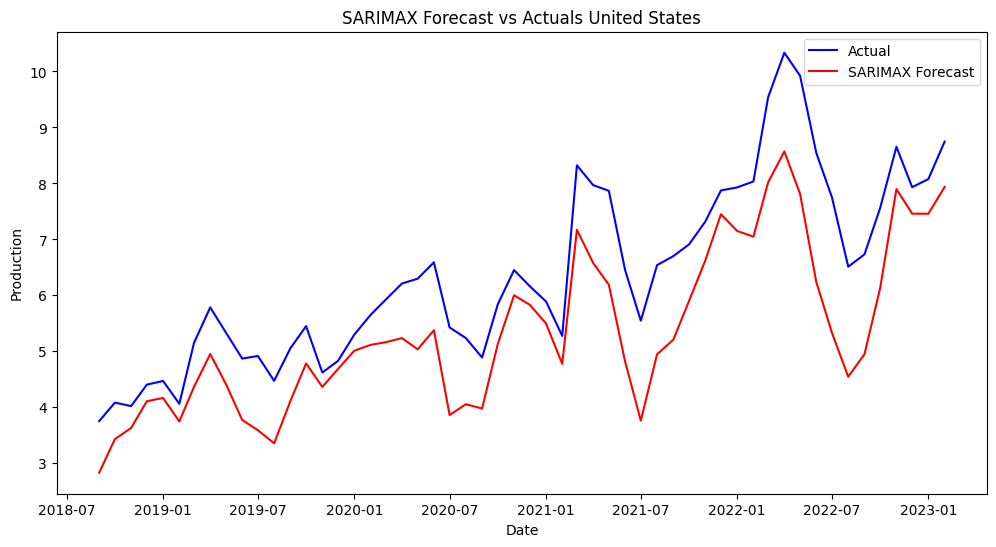

In [156]:
### Plot SARIMAX forecast vs actuals for 'other_united_states'
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['other_united_states'], label='Actual', color='blue')
plt.plot(test_data.index, sarimax_forecast_other_us, label='SARIMAX Forecast', color='red')
plt.title('SARIMAX Forecast vs Actuals United States')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()


COMPARE ALL MODELS:

# Deep Learning Models

### CNN Model

In [163]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=1))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse')


In [164]:
# Train CNN Model
cnn_history = cnn_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_val_lstm, y_val), verbose=1)


Epoch 1/50
5/5 [==============================] - 2s 99ms/step - loss: 0.9815 - val_loss: 8.1133
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 0.8185 - val_loss: 6.7316
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6696 - val_loss: 5.5062
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 0.5449 - val_loss: 4.3982
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 0.4299 - val_loss: 3.4298
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 0.3293 - val_loss: 2.4998
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 0.2487 - val_loss: 1.6457
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 0.1636 - val_loss: 1.0105
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 0.0981 - val_loss: 0.5715
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0593 - val_loss: 0.2583
Epoch 11/50
5/5 [============

In [165]:
# Make predictions using CNN Model
cnn_predictions = cnn_model.predict(X_test_lstm)
cnn_predictions = scalers['wind_united_states'].inverse_transform(cnn_predictions)

2/2 [==============================] - 0s 11ms/step


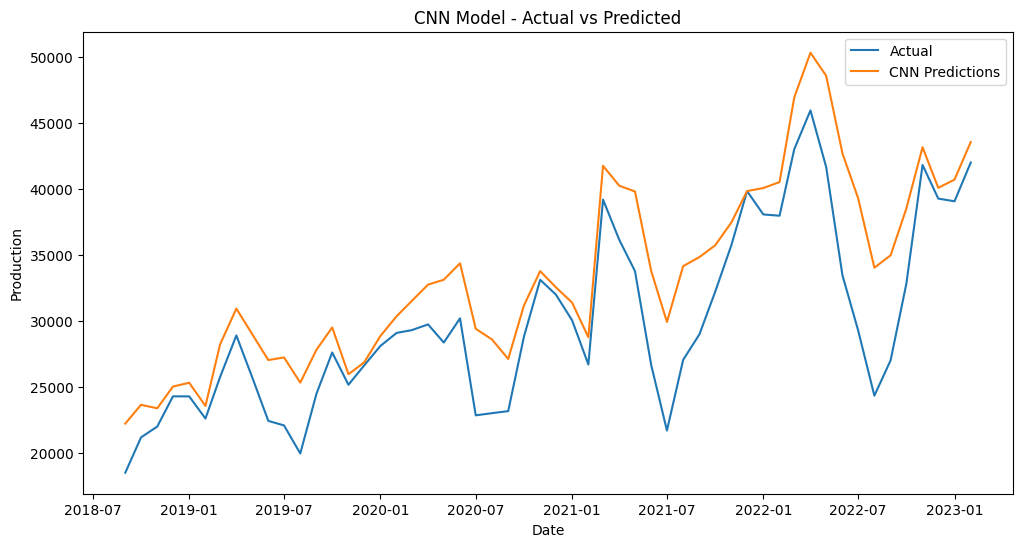

In [166]:

# Plot actual vs predicted for CNN
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, scalers['wind_united_states'].inverse_transform(y_test), label='Actual')
plt.plot(test_data.index, cnn_predictions, label='CNN Predictions')
plt.title('CNN Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

### LSTM Model

In [167]:

lstm_model = Sequential()
lstm_model.add(LSTM(units=50, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [168]:
# Train LSTM Model
lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_val_lstm, y_val), verbose=1)

Epoch 1/50
5/5 [==============================] - 7s 317ms/step - loss: 1.0457 - val_loss: 8.9986
Epoch 2/50
5/5 [==============================] - 0s 29ms/step - loss: 1.0128 - val_loss: 8.6810
Epoch 3/50
5/5 [==============================] - 0s 30ms/step - loss: 0.9792 - val_loss: 8.3725
Epoch 4/50
5/5 [==============================] - 0s 35ms/step - loss: 0.9469 - val_loss: 8.0629
Epoch 5/50
5/5 [==============================] - 0s 38ms/step - loss: 0.9183 - val_loss: 7.7442
Epoch 6/50
5/5 [==============================] - 0s 32ms/step - loss: 0.8850 - val_loss: 7.4400
Epoch 7/50
5/5 [==============================] - 0s 32ms/step - loss: 0.8548 - val_loss: 7.1317
Epoch 8/50
5/5 [==============================] - 0s 35ms/step - loss: 0.8255 - val_loss: 6.8109
Epoch 9/50
5/5 [==============================] - 0s 30ms/step - loss: 0.7921 - val_loss: 6.5155
Epoch 10/50
5/5 [==============================] - 0s 18ms/step - loss: 0.7615 - val_loss: 6.2139
Epoch 11/50
5/5 [===========

In [169]:
# Make predictions using LSTM Model
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions = scalers['wind_united_states'].inverse_transform(lstm_predictions)

2/2 [==============================] - 1s 14ms/step


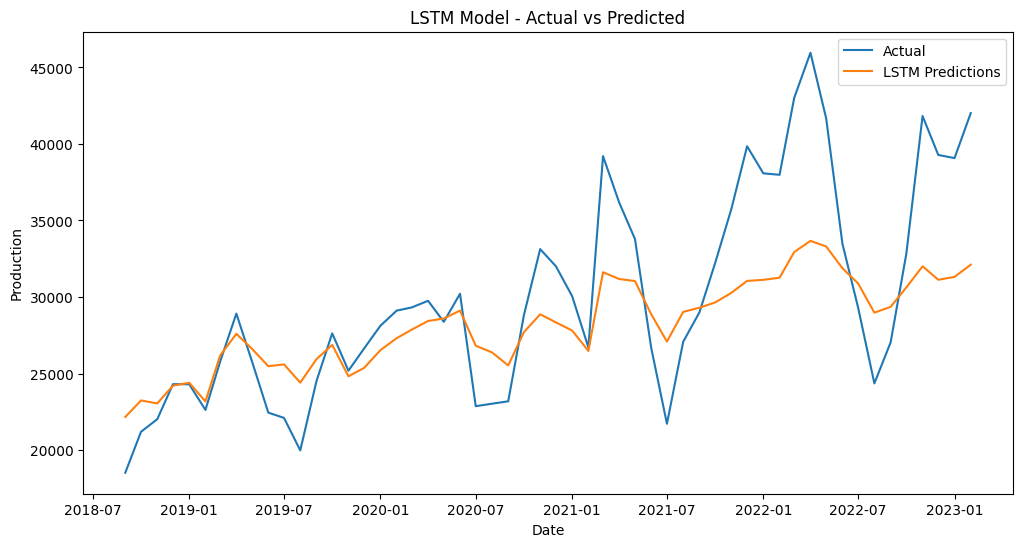

In [170]:
# Plot actual vs predicted for LSTM
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, scalers['wind_united_states'].inverse_transform(y_test), label='Actual')
plt.plot(test_data.index, lstm_predictions, label='LSTM Predictions')
plt.title('LSTM Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

In [171]:
# TCN Model
tcn_model = Sequential()
tcn_model.add(TCN(input_shape=(1, X_train_tcn.shape[2]), nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8]))
tcn_model.add(Dense(1))
tcn_model.compile(optimizer='adam', loss='mse')

In [172]:
# Train TCN Model
tcn_history = tcn_model.fit(X_train_tcn, y_train, epochs=50, batch_size=32, validation_data=(X_val_tcn, y_val), verbose=1)

Epoch 1/50
5/5 [==============================] - 5s 186ms/step - loss: 1.5965 - val_loss: 33.3378
Epoch 2/50
5/5 [==============================] - 0s 32ms/step - loss: 0.7772 - val_loss: 1.6355
Epoch 3/50
5/5 [==============================] - 0s 35ms/step - loss: 0.3185 - val_loss: 0.5934
Epoch 4/50
5/5 [==============================] - 0s 27ms/step - loss: 0.1139 - val_loss: 2.9354
Epoch 5/50
5/5 [==============================] - 0s 64ms/step - loss: 0.0858 - val_loss: 0.2817
Epoch 6/50
5/5 [==============================] - 0s 55ms/step - loss: 0.0327 - val_loss: 0.1336
Epoch 7/50
5/5 [==============================] - 0s 48ms/step - loss: 0.0276 - val_loss: 0.6184
Epoch 8/50
5/5 [==============================] - 0s 47ms/step - loss: 0.0133 - val_loss: 0.2755
Epoch 9/50
5/5 [==============================] - 0s 41ms/step - loss: 0.0138 - val_loss: 0.4118
Epoch 10/50
5/5 [==============================] - 0s 56ms/step - loss: 0.0089 - val_loss: 0.3155
Epoch 11/50
5/5 [==========

In [173]:
# Make predictions using TCN Model
tcn_predictions = tcn_model.predict(X_test_tcn)
tcn_predictions = scalers['wind_united_states'].inverse_transform(tcn_predictions)

2/2 [==============================] - 1s 9ms/step


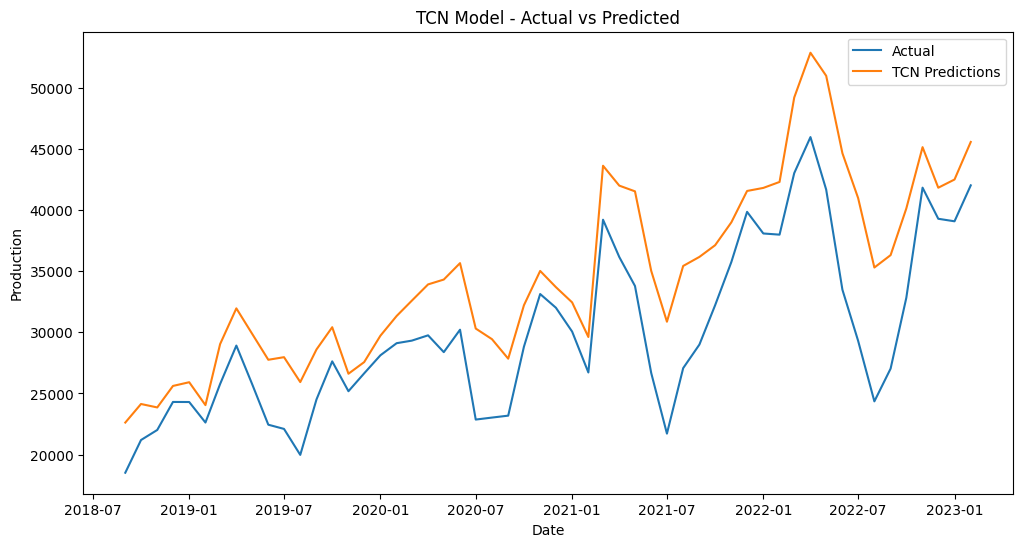

In [174]:
# Plot actual vs predicted for TCN
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, scalers['wind_united_states'].inverse_transform(y_test), label='Actual')
plt.plot(test_data.index, tcn_predictions, label='TCN Predictions')
plt.title('TCN Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

In [175]:
# CNN-LSTM Model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
cnn_lstm_model.add(MaxPooling1D(pool_size=1))
cnn_lstm_model.add(LSTM(units=50))
cnn_lstm_model.add(Dense(1))
cnn_lstm_model.compile(optimizer='adam', loss='mse')

In [176]:
# Train CNN-LSTM Model
cnn_lstm_history = cnn_lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_val_lstm, y_val), verbose=1)

Epoch 1/50
5/5 [==============================] - 8s 222ms/step - loss: 0.9507 - val_loss: 7.3839
Epoch 2/50
5/5 [==============================] - 0s 15ms/step - loss: 0.8646 - val_loss: 6.7177
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 0.7799 - val_loss: 6.0612
Epoch 4/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6926 - val_loss: 5.3702
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 0.6048 - val_loss: 4.6089
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 0.5126 - val_loss: 3.8002
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 0.4112 - val_loss: 2.9774
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 0.3159 - val_loss: 2.1318
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 0.2171 - val_loss: 1.3864
Epoch 10/50
5/5 [==============================] - 0s 24ms/step - loss: 0.1355 - val_loss: 0.7638
Epoch 11/50
5/5 [===========

In [177]:
# Make predictions using CNN-LSTM Model
cnn_lstm_predictions = cnn_lstm_model.predict(X_test_lstm)
cnn_lstm_predictions = scalers['wind_united_states'].inverse_transform(cnn_lstm_predictions)

2/2 [==============================] - 1s 12ms/step


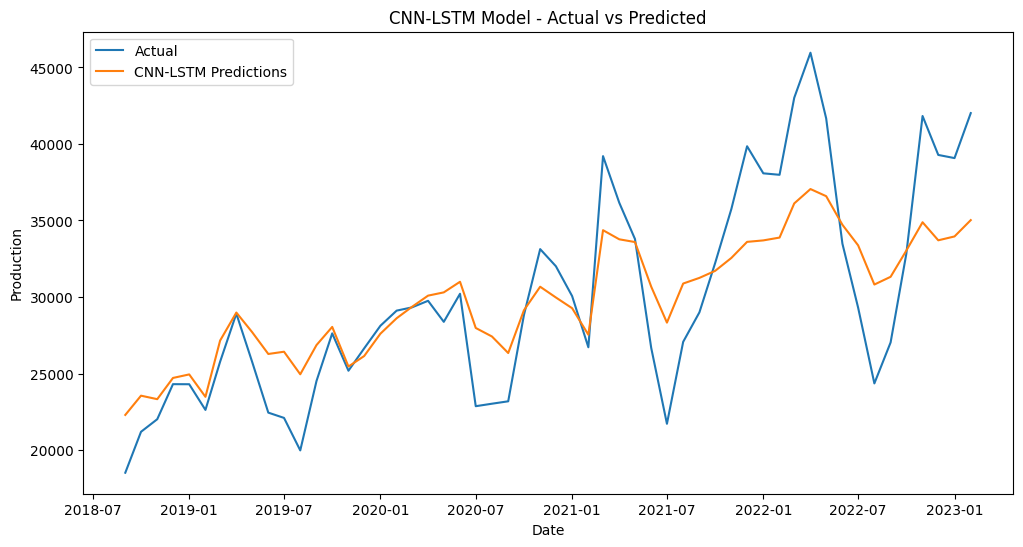

In [178]:
# Plot actual vs predicted for CNN-LSTM
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, scalers['wind_united_states'].inverse_transform(y_test), label='Actual')
plt.plot(test_data.index, cnn_lstm_predictions, label='CNN-LSTM Predictions')
plt.title('CNN-LSTM Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

### Model Evaluation

In [179]:
## Evaluation function
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

## Evaluate models
model_names = ['CNN', 'LSTM', 'TCN', 'CNN-LSTM']
predictions = [cnn_predictions, lstm_predictions, tcn_predictions, cnn_lstm_predictions]
results = {}

In [180]:
for model_name, preds in zip(model_names, predictions):
    mse, mae, r2 = evaluate_model(y_test, preds)
    results[model_name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{model_name} - MSE: {mse}, MAE: {mae}, R2: {r2}")

CNN - MSE: 1165336492.8261597, MAE: 33448.83741060581, R2: -584928368.098924
LSTM - MSE: 805032173.1621262, MAE: 28227.444723973866, R2: -404077412.70726126
TCN - MSE: 1255166292.4258757, MAE: 34657.74011604563, R2: -630017489.1380464
CNN-LSTM - MSE: 907527965.7016351, MAE: 29892.432969054884, R2: -455524095.3939419


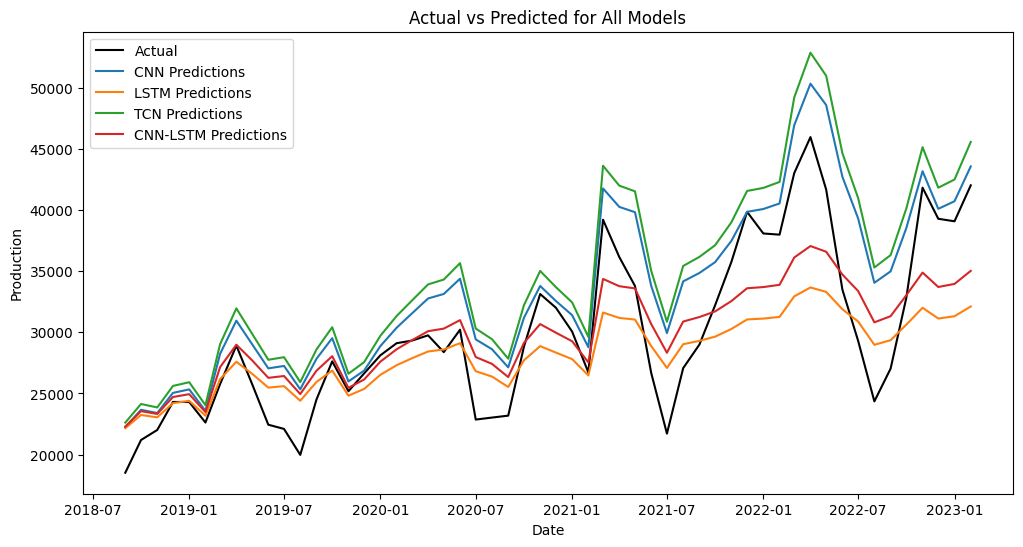

In [182]:
## Plot actual vs predicted for all models
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, scalers['wind_united_states'].inverse_transform(y_test), label='Actual', color='black')

for model_name, preds in zip(model_names, predictions):
    plt.plot(test_data.index, preds, label=f'{model_name} Predictions')

plt.title('Actual vs Predicted for All Models')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()


# Hyperparameter Tuning -Deeplearning Models

### CNN Hyperparameter Tuning

In [200]:

def build_cnn_model(hp):
    cnn_model = Sequential()
    cnn_model.add(Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=64, step=32),
        kernel_size=1,  # Fixed to 1 to prevent dimension issues
        activation='relu',
        input_shape=(X_train_lstm.shape[1], 1)
    ))
    cnn_model.add(MaxPooling1D(pool_size=1))  # Fixed to 1 to prevent dimension issues
    cnn_model.add(Flatten())
    cnn_model.add(Dense(
        units=hp.Int('units', min_value=50, max_value=100, step=50),
        activation='relu'
    ))
    cnn_model.add(Dense(1))
    cnn_model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='mse'
    )
    return cnn_model

In [222]:
### Hyperparameter tuning
tunerr = kt.RandomSearch(
    build_cnn_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='my_dir',
    project_name='cnn_wind_energy'
)

Reloading Tuner from my_dir/cnn_wind_energy/tuner0.json


In [223]:
tunerr.search_space_summary()

### Run the tuner search
tunerr.search(X_train_lstm, y_train, epochs=50, validation_data=(X_val_lstm, y_val), verbose=1)

### Get the optimal hyperparameters
best_hps = tunerr.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters in the Conv1D layer is {best_hps.get('filters')},
the optimal number of units in the Dense layer is {best_hps.get('units')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 11 Complete [00h 00m 17s]
val_loss: 0.0712185725569725

Best val_loss So Far: 0.06960247457027435
Total elapsed time: 00h 22m 21s

The hyperparameter search is complete. The optimal number of filters in the Conv1D layer is 64,
the optimal number of units in the Dense layer is 50,
and the optimal learning rate for the optimizer is 0.01.



In [224]:
### Build the model with the optimal hyperparameters and train it
cnn_model = tunerr.hypermodel.build(best_hps)
cnn_history = cnn_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_val_lstm, y_val), verbose=1)


Epoch 1/50
5/5 [==============================] - 2s 59ms/step - loss: 0.3365 - val_loss: 0.7578
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 0.1030 - val_loss: 0.4835
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0246 - val_loss: 0.2576
Epoch 4/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0378 - val_loss: 0.0712
Epoch 5/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0153 - val_loss: 0.6329
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0147 - val_loss: 0.2554
Epoch 7/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0081 - val_loss: 0.1269
Epoch 8/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0080 - val_loss: 0.3030
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0063 - val_loss: 0.3994
Epoch 10/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0055 - val_loss: 0.2472
Epoch 11/50
5/5 [============

In [225]:
### Make predictions using the tuned CNN model
cnn_predictions = cnn_model.predict(X_test_lstm)
cnn_predictions = scalers['wind_united_states'].inverse_transform(cnn_predictions)

2/2 [==============================] - 0s 10ms/step


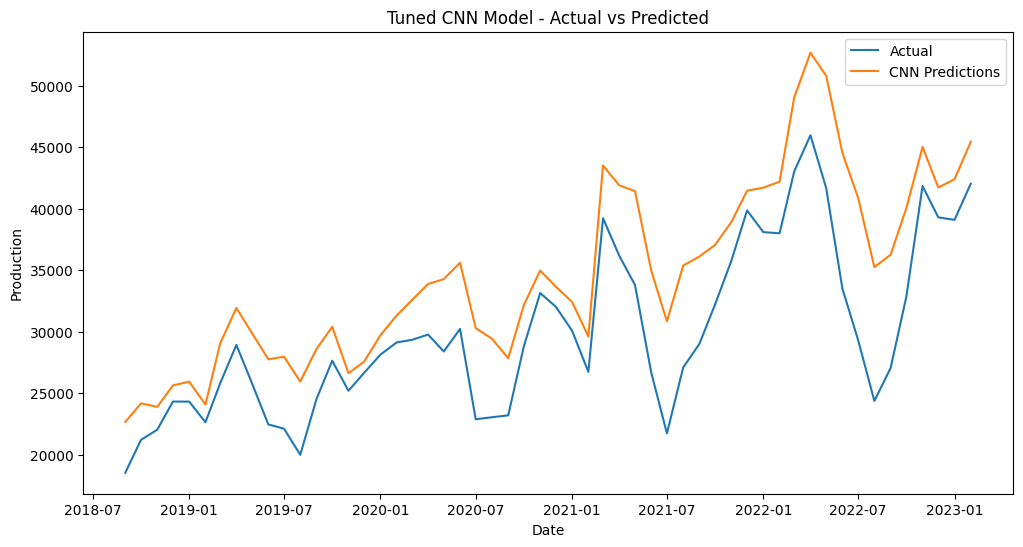

In [226]:
### Plot actual vs predicted for CNN
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, scalers['wind_united_states'].inverse_transform(y_test), label='Actual')
plt.plot(test_data.index, cnn_predictions, label='CNN Predictions')
plt.title('Tuned CNN Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

### LSTM Hyperparameter Tuning

In [227]:

def build_lstm_model(hp):
    lstm_model = Sequential()
    lstm_model.add(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        input_shape=(X_train_lstm.shape[1], 1),
        dropout=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.2, max_value=0.5, step=0.1),
        return_sequences=False
    ))
    lstm_model.add(Dense(1))
    lstm_model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='mse'
    )
    return lstm_model

In [228]:
### Hyperparameter tuning
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_wind_energy'
)
tuner.search_space_summary()

Reloading Tuner from my_dir/lstm_wind_energy/tuner0.json
Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
recurrent_dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [229]:
### Run the tuner search
tuner.search(X_train_lstm, y_train, epochs=50, validation_data=(X_val_lstm, y_val), verbose=1)

### Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM layer is {best_hps.get('units')},
the optimal dropout is {best_hps.get('dropout')},
the optimal recurrent_dropout is {best_hps.get('recurrent_dropout')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 50 Complete [00h 00m 16s]
val_loss: 0.07051273435354233

Best val_loss So Far: 0.06793839484453201
Total elapsed time: 00h 25m 40s

The hyperparameter search is complete. The optimal number of units in the LSTM layer is 200,
the optimal dropout is 0.2,
the optimal recurrent_dropout is 0.4,
and the optimal learning rate for the optimizer is 0.001.



In [230]:
### Build the model with the optimal hyperparameters and train it
lstm_model = tuner.hypermodel.build(best_hps)
lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_val_lstm, y_val), verbose=1)

Epoch 1/50
5/5 [==============================] - 4s 119ms/step - loss: 0.9495 - val_loss: 7.9295
Epoch 2/50
5/5 [==============================] - 0s 23ms/step - loss: 0.8942 - val_loss: 7.2878
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 0.8374 - val_loss: 6.6629
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 0.7805 - val_loss: 6.0708
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 0.7538 - val_loss: 5.5176
Epoch 6/50
5/5 [==============================] - 0s 23ms/step - loss: 0.6979 - val_loss: 4.9535
Epoch 7/50
5/5 [==============================] - 0s 24ms/step - loss: 0.6040 - val_loss: 4.3679
Epoch 8/50
5/5 [==============================] - 0s 22ms/step - loss: 0.5473 - val_loss: 3.7940
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 0.5490 - val_loss: 3.1999
Epoch 10/50
5/5 [==============================] - 0s 19ms/step - loss: 0.4809 - val_loss: 2.6519
Epoch 11/50
5/5 [===========

In [231]:
### Make predictions using the tuned LSTM model
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions = scalers['wind_united_states'].inverse_transform(lstm_predictions)

2/2 [==============================] - 0s 13ms/step


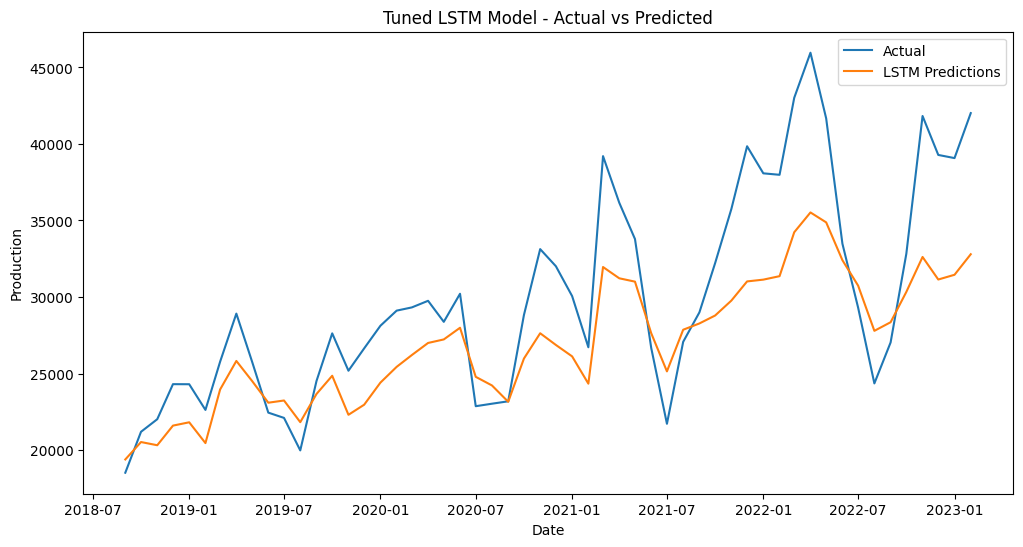

In [232]:
### Plot actual vs predicted for LSTM
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, scalers['wind_united_states'].inverse_transform(y_test), label='Actual')
plt.plot(test_data.index, lstm_predictions, label='LSTM Predictions')
plt.title('Tuned LSTM Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

### TCN Hyperparameter Tuning

In [214]:

def build_tcn_model(hp):
    tcn_model = Sequential()
    tcn_model.add(TCN(
        input_shape=(1, X_train_tcn.shape[2]),
        nb_filters=hp.Int('nb_filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values=[2, 3, 4]),
        dilations=[1, 2, 4, 8]
    ))
    tcn_model.add(Dense(1))
    tcn_model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='mse'
    )
    return tcn_model


In [216]:
### Hyperparameter tuning
tuner = kt.RandomSearch(
    build_tcn_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='my_dir',
    project_name='tcn_wind_energy'
)
tuner.search_space_summary()

Search space summary
Default search space size: 3
nb_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [217]:

### Run the tuner search
tuner.search(X_train_tcn, y_train, epochs=50, validation_data=(X_val_tcn, y_val), verbose=1)


Trial 32 Complete [00h 00m 17s]
val_loss: 0.14761961996555328

Best val_loss So Far: 0.06918726861476898
Total elapsed time: 00h 08m 39s


In [218]:
### Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters in the TCN layer is {best_hps.get('nb_filters')},
the optimal kernel size is {best_hps.get('kernel_size')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of filters in the TCN layer is 32,
the optimal kernel size is 3,
and the optimal learning rate for the optimizer is 0.0001.



In [219]:
### Build the model with the optimal hyperparameters and train it
tcn_model = tuner.hypermodel.build(best_hps)
tcn_history = tcn_model.fit(X_train_tcn, y_train, epochs=50, batch_size=32, validation_data=(X_val_tcn, y_val), verbose=1)

Epoch 1/50
5/5 [==============================] - 4s 132ms/step - loss: 0.9138 - val_loss: 9.3233
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 0.5798 - val_loss: 5.1356
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 0.3233 - val_loss: 2.2665
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 0.1527 - val_loss: 0.7215
Epoch 5/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0708 - val_loss: 0.1195
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0199 - val_loss: 0.1228
Epoch 7/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0067 - val_loss: 0.3787
Epoch 8/50
5/5 [==============================] - 0s 25ms/step - loss: 0.0069 - val_loss: 0.5866
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0098 - val_loss: 0.6669
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - val_loss: 0.6456
Epoch 11/50
5/5 [===========

In [220]:
### Make predictions using the tuned TCN model
tcn_predictions = tcn_model.predict(X_test_tcn)
tcn_predictions = scalers['wind_united_states'].inverse_transform(tcn_predictions)

2/2 [==============================] - 0s 8ms/step


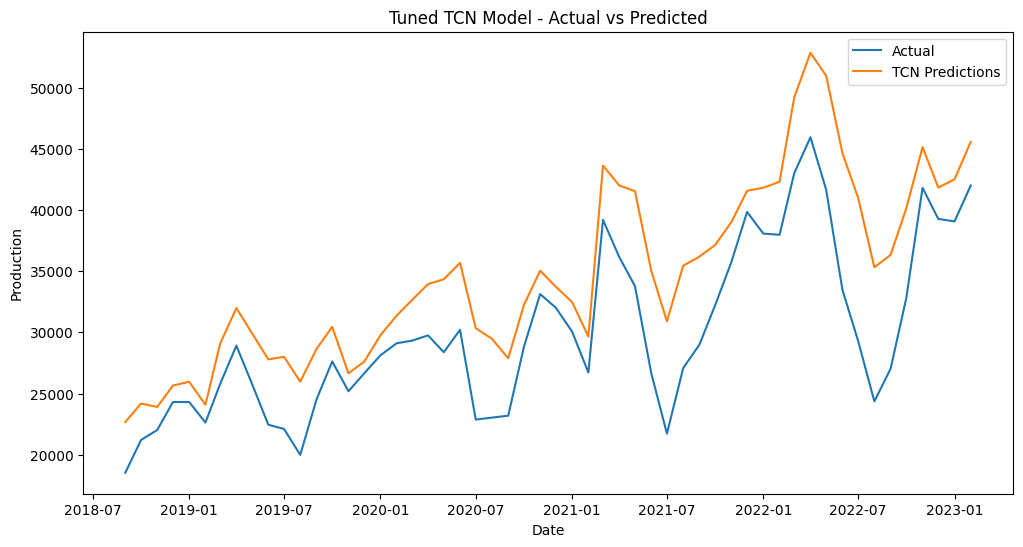

In [221]:
### Plot actual vs predicted for TCN
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, scalers['wind_united_states'].inverse_transform(y_test), label='Actual')
plt.plot(test_data.index, tcn_predictions, label='TCN Predictions')
plt.title('Tuned TCN Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

In [233]:
## CNN-LSTM Hyperparameter Tuning
def build_cnn_lstm_model(hp):
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add(Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=64, step=32),
        kernel_size=1,  # Fixed to prevent dimension issues
        activation='relu',
        input_shape=(X_train_lstm.shape[1], 1)
    ))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1))  # Fixed to prevent dimension issues
    cnn_lstm_model.add(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        dropout=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.2, max_value=0.5, step=0.1),
        return_sequences=False
    ))
    cnn_lstm_model.add(Dense(1))
    cnn_lstm_model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='mse'
    )
    return cnn_lstm_model

In [234]:
### Hyperparameter tuning
tuner = kt.RandomSearch(
    build_cnn_lstm_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='my_dir',
    project_name='cnn_lstm_wind_energy'
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
recurrent_dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [235]:
### Run the tuner search
tuner.search(X_train_lstm, y_train, epochs=10, validation_data=(X_val_lstm, y_val), verbose=1)

### Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters in the Conv1D layer is {best_hps.get('filters')},
the optimal number of units in the LSTM layer is {best_hps.get('units')},
the optimal dropout is {best_hps.get('dropout')},
the optimal recurrent_dropout is {best_hps.get('recurrent_dropout')},
and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 50 Complete [00h 00m 09s]
val_loss: 0.23025770485401154

Best val_loss So Far: 0.07252132892608643
Total elapsed time: 00h 08m 08s

The hyperparameter search is complete. The optimal number of filters in the Conv1D layer is 64,
the optimal number of units in the LSTM layer is 100,
the optimal dropout is 0.2,
the optimal recurrent_dropout is 0.4,
and the optimal learning rate for the optimizer is 0.001.



In [236]:
### Build the model with the optimal hyperparameters and train it
cnn_lstm_model = tuner.hypermodel.build(best_hps)
cnn_lstm_history = cnn_lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_val_lstm, y_val), verbose=1)

Epoch 1/50
5/5 [==============================] - 5s 160ms/step - loss: 0.8962 - val_loss: 6.2889
Epoch 2/50
5/5 [==============================] - 0s 24ms/step - loss: 0.7153 - val_loss: 4.5565
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 0.5506 - val_loss: 2.9130
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 0.4057 - val_loss: 1.4651
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 0.2266 - val_loss: 0.4799
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 0.1163 - val_loss: 0.0814
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0385 - val_loss: 0.2805
Epoch 8/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0182 - val_loss: 0.5984
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 0.0272 - val_loss: 0.6042
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 0.0251 - val_loss: 0.3696
Epoch 11/50
5/5 [===========

In [237]:
### Make predictions using the tuned CNN-LSTM model
cnn_lstm_predictions = cnn_lstm_model.predict(X_test_lstm)
cnn_lstm_predictions = scalers['wind_united_states'].inverse_transform(cnn_lstm_predictions)


2/2 [==============================] - 0s 8ms/step


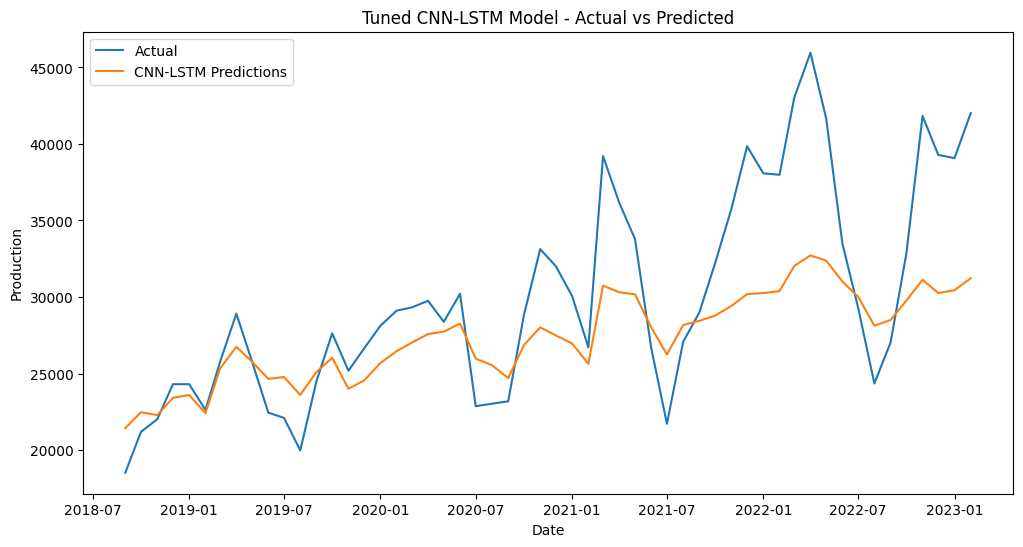

In [238]:
### Plot actual vs predicted for CNN-LSTM
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, scalers['wind_united_states'].inverse_transform(y_test), label='Actual')
plt.plot(test_data.index, cnn_lstm_predictions, label='CNN-LSTM Predictions')
plt.title('Tuned CNN-LSTM Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

### Model Evaluation after Tuning

In [239]:

## Evaluate models
model_names = ['CNN', 'LSTM', 'TCN', 'CNN-LSTM']
predictions = [cnn_predictions, lstm_predictions, tcn_predictions, cnn_lstm_predictions]
results = {}

for model_name, preds in zip(model_names, predictions):
    mse, mae, r2 = evaluate_model(y_test, preds)
    results[model_name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{model_name} - MSE: {mse}, MAE: {mae}, R2: {r2}")


CNN - MSE: 1250265574.1077847, MAE: 34598.016230050256, R2: -627557625.2353361
LSTM - MSE: 746346497.8928034, MAE: 27015.60737588359, R2: -374620756.5945665
TCN - MSE: 1257250281.4565568, MAE: 34689.021112862756, R2: -631063525.4652706
CNN-LSTM - MSE: 757764413.3996475, MAE: 27380.88131974933, R2: -380351858.9302795


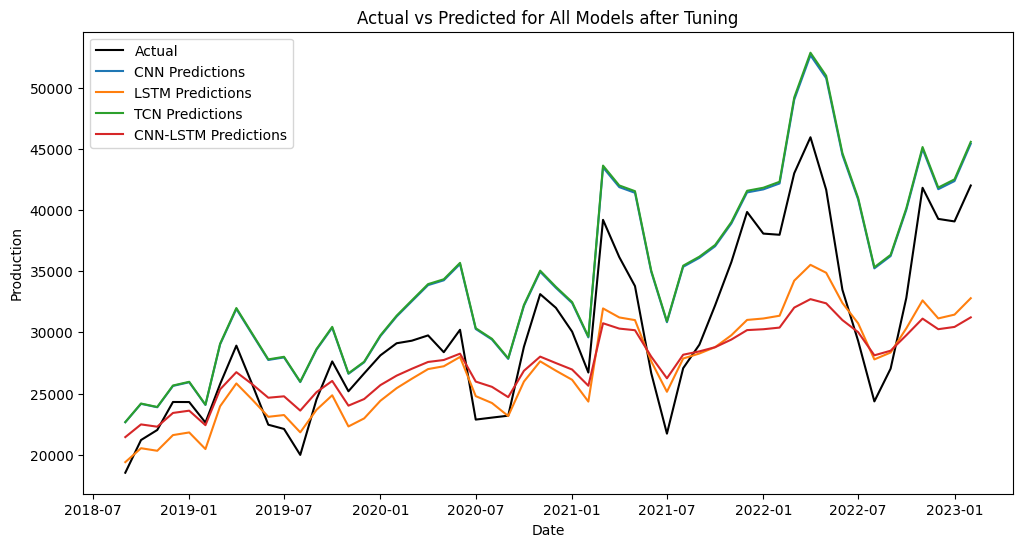

In [240]:
## Plot actual vs predicted for all models after tuning
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, scalers['wind_united_states'].inverse_transform(y_test), label='Actual', color='black')

for model_name, preds in zip(model_names, predictions):
    plt.plot(test_data.index, preds, label=f'{model_name} Predictions')

plt.title('Actual vs Predicted for All Models after Tuning')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()